## クラウドファンディングが始まる前に成功するかを予測する

* caggleよりデータセットを取得
* データセット：Kickstarter Projects

In [1]:
#ライブラリ読み込み
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import log_loss, accuracy_score, confusion_matrix,precision_recall_fscore_support

### 1.データの読み込み

|カラム名|内容|
|:-|:-|
|ID|ID|
|category|カテゴリ|
|main_category|メインカテゴリ|
|currency|通貨|
|deadline|締め切り|
|goal|プロジェクトの目標額|
|launched|プロジェクト開始日|
|pledged|集まった資金額|
|state|状態|
|backers|集まった支援者|
|country|国|
|usd_pledged|集まった資金額usdドル換算|
|usd_pledged_real|集まった資金額usdドル換算|
|usd_goal_real|プロジェクトの目標額usdドル換算|

* 目的変数：state
* pledged,usd_pledged,usd_pledged_real,backersはクラウドファンディング終了時に決まる値なので説明変数に使用しない
* ID,nameは分析に不要

In [2]:
df = pd.read_csv('ks-projects-201801.csv')
display(df.head())
df.describe()

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.0,failed,0,GB,0.0,0.0,1533.95
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.0,failed,15,US,100.0,2421.0,30000.00
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.0,failed,3,US,220.0,220.0,45000.00
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,1.0,failed,1,US,1.0,1.0,5000.00
4,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,19500.0,2015-07-04 08:35:03,1283.0,canceled,14,US,1283.0,1283.0,19500.00


,ID,goal,pledged,backers,usd pledged,usd_pledged_real,usd_goal_real
count,3.786610e+05,3.786610e+05,3.786610e+05,378661.000000,3.748640e+05,3.786610e+05,3.786610e+05
mean,1.074731e+09,4.908079e+04,9.682979e+03,105.617476,7.036729e+03,9.058924e+03,4.545440e+04
std,6.190862e+08,1.183391e+06,9.563601e+04,907.185035,7.863975e+04,9.097334e+04,1.152950e+06
min,5.971000e+03,1.000000e-02,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,1.000000e-02
25%,5.382635e+08,2.000000e+03,3.000000e+01,2.000000,1.698000e+01,3.100000e+01,2.000000e+03
50%,1.075276e+09,5.200000e+03,6.200000e+02,12.000000,3.947200e+02,6.243300e+02,5.500000e+03
75%,1.610149e+09,1.600000e+04,4.076000e+03,56.000000,3.034090e+03,4.050000e+03,1.550000e+04
max,2.147476e+09,1.000000e+08,2.033899e+07,219382.000000,2.033899e+07,2.033899e+07,1.663614e+08


#### 欠損値確認

In [3]:
df.isnull().sum()

ID                     0
name                   4
category               0
main_category          0
currency               0
deadline               0
goal                   0
launched               0
pledged                0
state                  0
backers                0
country                0
usd pledged         3797
usd_pledged_real       0
usd_goal_real          0
dtype: int64

* nameは説明変数に使用しないので欠損値処理なし
* usd pledgedは説明変数に使用しないので欠損値処理なし

#### stateの値を確認
* 目的変数で使用するstateの値を確認する

In [4]:
df['state'].value_counts()

failed        197719
successful    133956
canceled       38779
undefined       3562
live            2799
suspended       1846
Name: state, dtype: int64

#### stateの値から不要なレコードを取り除く
* successful,failedのみ使用する

In [5]:
df_cloud = df[(df['state'] == 'successful') |(df['state'] == 'failed')].copy()
display(df_cloud['state'].value_counts())

failed        197719
successful    133956
Name: state, dtype: int64

#### state_flgを追加
* stateの値がsuccessful→state_flg:1

In [6]:
# state successful→1 successful以外を0にする
df_cloud['state_flg'] = 0
df_cloud['state_flg'] = df_cloud['state_flg'].mask(df_cloud['state'] == 'successful',1)
display(df_cloud.loc[:,['state','state_flg']].head())
df_cloud['state_flg'].value_counts()

,state,state_flg
0,failed,0
1,failed,0
2,failed,0
3,failed,0
5,successful,1


0    197719
1    133956
Name: state_flg, dtype: int64

#### 分析に不要な列を除く
* ID,name,pledged,usd pledged,usd_pledged_real,backersを削除

In [7]:
df_cloud = df_cloud.drop(['ID','name','pledged','usd pledged','usd_pledged_real','backers'],axis=1)
df_cloud.head()

,category,main_category,currency,deadline,goal,launched,state,country,usd_goal_real,state_flg
0,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,failed,GB,1533.95,0
1,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,failed,US,30000.00,0
2,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,failed,US,45000.00,0
3,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,failed,US,5000.00,0
5,Restaurants,Food,USD,2016-04-01,50000.0,2016-02-26 13:38:27,successful,US,50000.00,1


### 2.グラフ作成
* グラフを作成し説明変数を見つける

#### 散布図行列を作成
* 散布図行列を作成し、量的データの相関関係を確認する

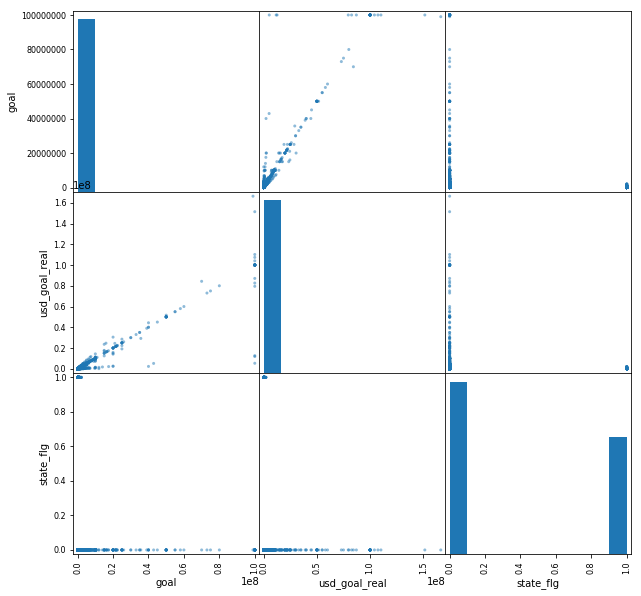

In [8]:
# 散布図行列
pd.plotting.scatter_matrix(df_cloud, figsize=(10,10))
plt.show()

#### goal,usd_goal_real
* goalとusd_goal_realに相関関係がある
* failed,successfulを分けて表示する

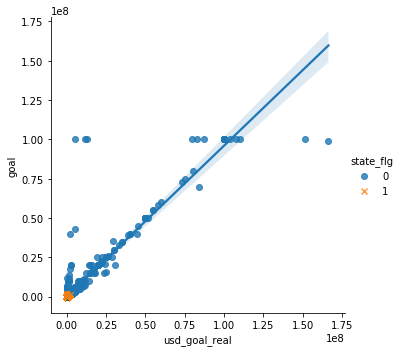

In [9]:
sns.lmplot(x="usd_goal_real", y="goal", hue="state_flg", data=df_cloud, markers=["o", "x"])

* 原点でつぶれていて、分類可能かわかりづらい
* usd_goal_realは、goalのusdドルに換算した値なので、どちらか1つあればよいと考える
* usdドルに換算された値のほうが扱いやすそうなので今回は、usd_goal_realを使用する

#### country
* 国ごとに成功率が異なっているか確認する

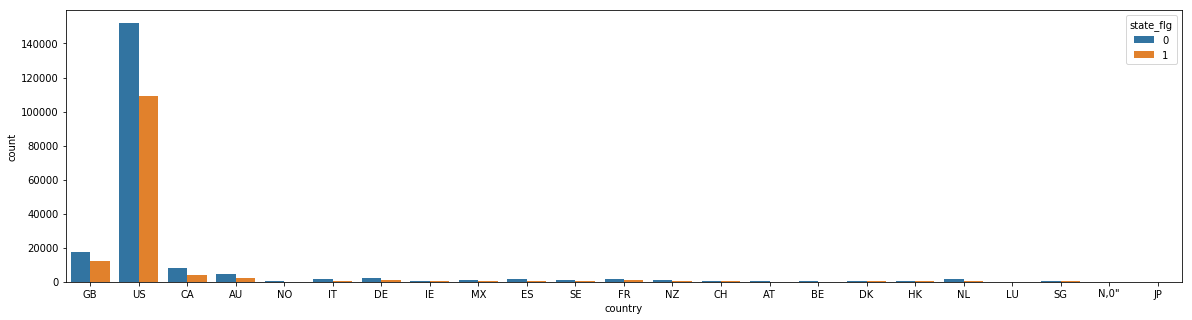

In [10]:
# 国別の失敗、成功数を表示
plt.figure(figsize=(20,5))
sns.countplot(data=df_cloud, x='country',hue='state_flg')

,state_flg
country,
AT,0.220619
AU,0.303809
BE,0.290631
CA,0.334196
CH,0.286810
DE,0.272701
DK,0.388769
ES,0.262680
FR,0.360317


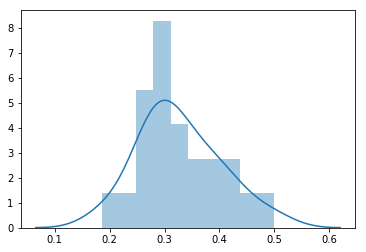

In [11]:
# 国別の成功率のばらつき具合
display(df_cloud.groupby('country').mean().loc[:,['state_flg']])
sns.distplot(df_cloud.groupby('country').mean().loc[:,['state_flg']],bins=10)

* 0.3付近を中心とした山なりの形。なので説明変数に追加してみる
* currencyはcountryがあれば不要そうなので今回使用しない

#### main_category
* main_categoryごとに成功率が異なっているか確認

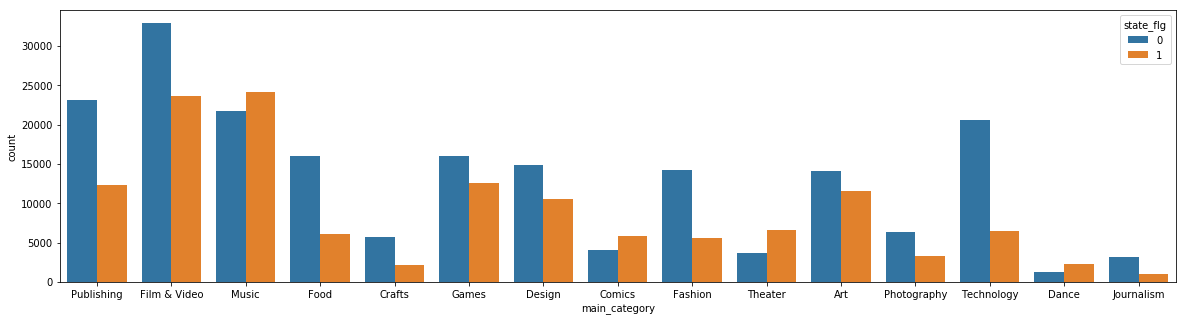

In [12]:
plt.figure(figsize=(20,5))
sns.countplot(data=df_cloud, x='main_category',hue='state_flg')

,state_flg
main_category,
Art,0.448890
Comics,0.591415
Crafts,0.270530
Dance,0.654352
Design,0.415944
Fashion,0.282832
Film & Video,0.417906
Food,0.275914
Games,0.438905


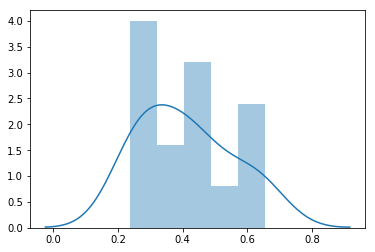

In [13]:
# main_categoryの成功率のばらつき具合
display(df_cloud.groupby('main_category').mean().loc[:,['state_flg']])
sns.distplot(df_cloud.groupby('main_category').mean().loc[:,['state_flg']],bins=5)

* きれいな分布ではないので、説明変数に追加しない。

#### category
* categoryごとに成功率が異なっているか確認

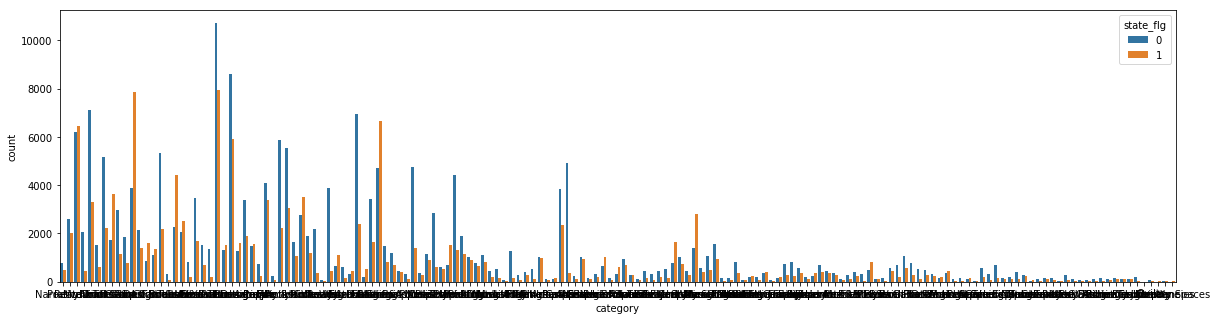

In [14]:
plt.figure(figsize=(20,5))
sns.countplot(data=df_cloud, x='category',hue='state_flg')

,state_flg
category,
3D Printing,0.426056
Academic,0.241956
Accessories,0.391606
Action,0.172303
Animals,0.275109
Animation,0.308179
Anthologies,0.706920
Apparel,0.229322
Apps,0.071496


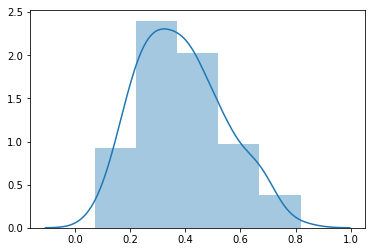

In [15]:
# categoryの成功率のばらつき具合
display(df_cloud.groupby('category').mean().loc[:,['state_flg']])
sns.distplot(df_cloud.groupby('category').mean().loc[:,['state_flg']],bins=5)

* 山なりの形なので説明変数に追加してみる

#### 期間(deadline - launched) days
* deadline - launched から期間days列を作成する
* プロジェクト期間の長さが成功率に影響がないか確認する
* usd_goal_realとdaysの相関関係を確認する

In [16]:
# 期間の長さを求める
df_cloud['launched'] = pd.to_datetime(df_cloud['launched'])
df_cloud['deadline'] = pd.to_datetime(df_cloud['deadline'])
df_cloud['period'] = df_cloud['deadline'] - df_cloud['launched']
df_cloud['period'].head()

0   58 days 11:47:32
1   59 days 19:16:03
2   44 days 23:39:10
3   29 days 20:35:49
5   34 days 10:21:33
Name: period, dtype: timedelta64[ns]

In [17]:
# daysだけ抽出
days = [] 
for i in df_cloud.index:
    days.append(df_cloud['period'][i].days)
#'days'の列を追加 
df_cloud['days'] = days
df_cloud['days'].head()

0    58
1    59
2    44
3    29
5    34
Name: days, dtype: int64

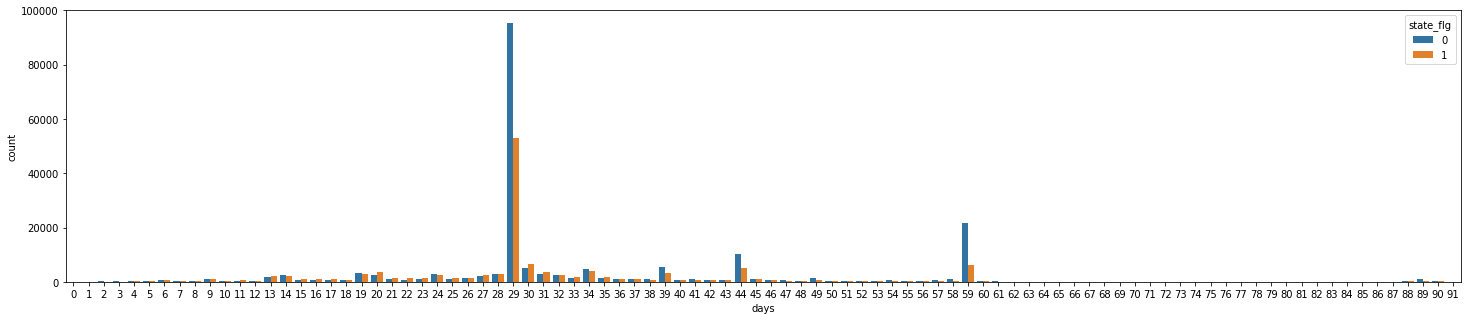

In [18]:
# ヒストグラム
plt.figure(figsize=(25,5))
sns.countplot(data=df_cloud, x='days',hue='state_flg')

,state_flg
days,
0,0.380435
1,0.426357
2,0.360825
3,0.423469
4,0.433036
5,0.483660
6,0.489647
7,0.570458
8,0.583333


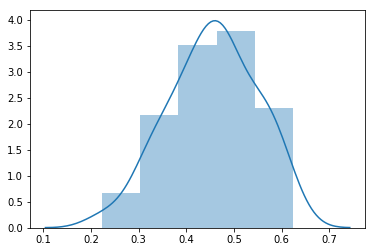

In [19]:
# daysの成功率のばらつき具合
display(df_cloud.groupby('days').mean().loc[:,['state_flg']])
sns.distplot(df_cloud.groupby('days').mean().loc[:,['state_flg']],bins=5)

#### usd_goal_realとdaysの相関関係

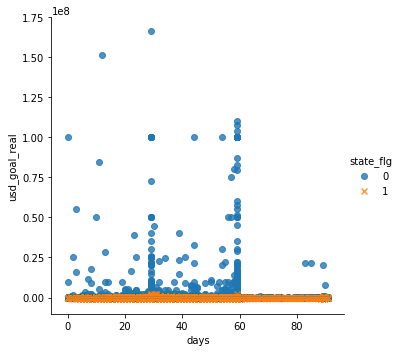

In [20]:
sns.lmplot(x="days", y="usd_goal_real", hue="state_flg", data=df_cloud, markers=["o", "x"])

* y=0付近に横線が引けるかもしれないが、つぶれていて判断できない。
* daysを説明変数に追加したパターンとしないパターンを実施してみる

### 3.ダミー変数を追加
* 質的データのうち説明変数に使用する変数をダミー変数に変換する

In [21]:
# country
df_cloud = pd.get_dummies(df_cloud,columns=['country'])
display(df_cloud.head())

,category,main_category,currency,deadline,goal,launched,state,usd_goal_real,state_flg,period,...,country_JP,country_LU,country_MX,"country_N,0""",country_NL,country_NO,country_NZ,country_SE,country_SG,country_US
0,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,failed,1533.95,0,58 days 11:47:32,...,0,0,0,0,0,0,0,0,0,0
1,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,failed,30000.00,0,59 days 19:16:03,...,0,0,0,0,0,0,0,0,0,1
2,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,failed,45000.00,0,44 days 23:39:10,...,0,0,0,0,0,0,0,0,0,1
3,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,failed,5000.00,0,29 days 20:35:49,...,0,0,0,0,0,0,0,0,0,1
5,Restaurants,Food,USD,2016-04-01,50000.0,2016-02-26 13:38:27,successful,50000.00,1,34 days 10:21:33,...,0,0,0,0,0,0,0,0,0,1


In [22]:
# category
df_cloud = pd.get_dummies(df_cloud,columns=['category'])
display(df_cloud.head())

,main_category,currency,deadline,goal,launched,state,usd_goal_real,state_flg,period,days,...,category_Wearables,category_Weaving,category_Web,category_Webcomics,category_Webseries,category_Woodworking,category_Workshops,category_World Music,category_Young Adult,category_Zines
0,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,failed,1533.95,0,58 days 11:47:32,58,...,0,0,0,0,0,0,0,0,0,0
1,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,failed,30000.00,0,59 days 19:16:03,59,...,0,0,0,0,0,0,0,0,0,0
2,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,failed,45000.00,0,44 days 23:39:10,44,...,0,0,0,0,0,0,0,0,0,0
3,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,failed,5000.00,0,29 days 20:35:49,29,...,0,0,0,0,0,0,0,0,0,0
5,Food,USD,2016-04-01,50000.0,2016-02-26 13:38:27,successful,50000.00,1,34 days 10:21:33,34,...,0,0,0,0,0,0,0,0,0,0


### 3.ロジステック回帰
#### usd_goal_real,country,days ロジステック回帰を行い結果を確認する

In [23]:
##### 使用しない列を削除
df_loss = df_cloud.drop(['main_category','currency','deadline','goal','launched','state','period'],axis=1)

In [24]:
display(df_loss.head())

,usd_goal_real,state_flg,days,country_AT,country_AU,country_BE,country_CA,country_CH,country_DE,country_DK,...,category_Wearables,category_Weaving,category_Web,category_Webcomics,category_Webseries,category_Woodworking,category_Workshops,category_World Music,category_Young Adult,category_Zines
0,1533.95,0,58,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,30000.00,0,59,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,45000.00,0,44,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,5000.00,0,29,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,50000.00,1,34,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [25]:
y = df_loss["state_flg"].values
X = df_loss.drop(['state_flg'],axis=1).values
clf = SGDClassifier(loss='log', penalty='none', max_iter=10000, fit_intercept=True, random_state=1234, tol=1e-3)
clf.fit(X, y)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=10000,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='none',
       power_t=0.5, random_state=1234, shuffle=True, tol=0.001,
       validation_fraction=0.1, verbose=0, warm_start=False)

#### 性能評価

In [26]:
# ラベルを予測
y_est = clf.predict(X)

# 対数尤度を表示
print('対数尤度 = {:.3f}'.format(- log_loss(y, y_est)))

# 正答率を表示
print('正答率 = {:.3f}%'.format(100 * accuracy_score(y, y_est)))

# Precision, Recall, F1-scoreを計算
precision, recall, f1_score, _ = precision_recall_fscore_support(y, y_est)
print('適合率（Precision） = {:.3f}%'.format(100 * precision[0]))
print('再現率（Recall） = {:.3f}%'.format(100 * recall[0]))
print('F1値（F1-score） = {:.3f}%'.format(100 * f1_score[0]))

対数尤度 = -15.413
正答率 = 55.376%
適合率（Precision） = 71.140%
再現率（Recall） = 42.305%
F1値（F1-score） = 53.058%


In [27]:
# 予測値と正解のクロス集計
conf_mat = pd.DataFrame(confusion_matrix(y, y_est), 
                        index=['正解 = failed', '正解 = successful'], 
                        columns=['予測 = failed', '予測 = successful'])
conf_mat

,予測 = failed,予測 = successful
正解 = failed,83646,114073
正解 = successful,33934,100022


#### daysを除いて ロジステック回帰を行い結果を確認する

In [28]:
y = df_loss["state_flg"].values
X = df_loss.drop(['state_flg','days'],axis=1).values
clf = SGDClassifier(loss='log', penalty='none', max_iter=10000, fit_intercept=True, random_state=1234, tol=1e-3)
clf.fit(X, y)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=10000,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='none',
       power_t=0.5, random_state=1234, shuffle=True, tol=0.001,
       validation_fraction=0.1, verbose=0, warm_start=False)

#### 性能評価

In [29]:
# ラベルを予測
y_est = clf.predict(X)

# 対数尤度を表示 errorになる
print('対数尤度 = {:.3f}'.format(- log_loss(y, y_est)))

# 正答率を表示
print('正答率 = {:.3f}%'.format(100 * accuracy_score(y, y_est)))

# Precision, Recall, F1-scoreを計算
precision, recall, f1_score, _ = precision_recall_fscore_support(y, y_est)
print('適合率（Precision） = {:.3f}%'.format(100 * precision[0]))
print('再現率（Recall） = {:.3f}%'.format(100 * recall[0]))
print('F1値（F1-score） = {:.3f}%'.format(100 * f1_score[0]))

対数尤度 = -13.885
正答率 = 59.798%
適合率（Precision） = 59.784%
再現率（Recall） = 99.482%
F1値（F1-score） = 74.685%


In [30]:
# 予測値と正解のクロス集計
conf_mat = pd.DataFrame(confusion_matrix(y, y_est), 
                        index=['正解 = failed', '正解 = successful'], 
                        columns=['予測 = failed', '予測 = successful'])
conf_mat

,予測 = failed,予測 = successful
正解 = failed,196695,1024
正解 = successful,132316,1640


* daysを除くとAccuracyは上がったが、Recallの数値が高すぎる